<a href="https://colab.research.google.com/github/VijayKalmath/MultiModal-KnowledgeDistillation/blob/main/zeroshot_evaluation_kd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

See https://github.com/openai/CLIP
and
https://arxiv.org/abs/2103.00020

Modified from
https://colab.research.google.com/github/openai/CLIP/blob/main/notebooks/Interacting_with_CLIP.ipynb
and
https://colab.research.google.com/github/openai/CLIP/blob/main/notebooks/Prompt_Engineering_for_ImageNet.ipynb

### setup

In [5]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5a2887b1-d634-ffb6-668c-cc421fb13903)


In [6]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-l2jjhtnh
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-l2jjhtnh


In [7]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

assert list(map(int, torch.__version__.split("+")[0].split("."))) >= [1, 7, 1], "PyTorch 1.7.1 or later is required"

Torch version: 1.12.1+cu113


### load model

In [8]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [9]:
# model, preprocess = clip.load("RN50")
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 75.0MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [11]:
from clip.model import VisionTransformer, convert_weights
patch_size = 32
width = 384
layers = 6
heads = 12
output_dim = 512

student_model = VisionTransformer(
    input_resolution=input_resolution,
    patch_size=patch_size,
    width=width,
    layers=layers,
    heads=heads,
    output_dim=output_dim,
)

student_model.load_state_dict(torch.load("/content/Final_DistilledModel.pt"))
convert_weights(student_model)

In [10]:
from clip.model import Transformer
from clip.model import convert_weights # Make them float16
# Set Student Configuration

width = 512
layers = 6
heads = 8 # More Number of Heads 

def build_attention_mask():
    context_length = 77 
    mask = torch.empty(context_length,context_length)
    mask.fill_(float("-inf"))
    mask.triu_(1)  # zero out the lower diagonal
    return mask
    
student_model_text = Transformer(
    width=width,
    layers=layers,
    heads=heads,
     attn_mask=build_attention_mask()
    
)
student_model_text.load_state_dict(torch.load("/content/Text_DistilledModel.pt"))
convert_weights(student_model_text)

### load data

In [12]:
import os

from torchvision.datasets import CIFAR100, CIFAR10, STL10
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True, train=False)
# cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True, train=False)
# stl10 = STL10(os.path.expanduser("~/.cache"), transform=preprocess, download=True, split="test")

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [13]:
cifar100

Dataset CIFAR100
    Number of datapoints: 10000
    Root location: /root/.cache
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               <function _convert_image_to_rgb at 0x7ff7150ac710>
               ToTensor()
               Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
           )

In [14]:
len(cifar100)

10000

In [15]:
norm = preprocess.transforms[-1]
def denormalize(img):
  return img * torch.tensor(norm.std)[:, None, None] + torch.tensor(norm.mean)[:, None, None]
norm.mean, norm.std

((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

(torch.Size([224, 224, 3]), tensor(0.1765), tensor(1.))

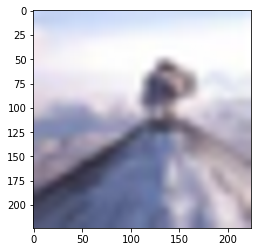

In [16]:
import matplotlib.pyplot as plt

img, label = next(iter(cifar100))
img = denormalize(img).permute(1, 2, 0)
plt.imshow(img)
img.shape, img.min(), img.max()

In [17]:
batch_size = 128
# batch_size = 32
data_loader = torch.utils.data.DataLoader(cifar100,
                                          batch_size=batch_size,
                                          shuffle=False)

In [20]:
x = next(iter(data_loader))
x[0].shape, x[1].shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

### show some examples

In [21]:
image_input, image_labels = next(iter(data_loader))
image_input = image_input.cuda()
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [22]:
with torch.no_grad():
  image_features = model.encode_image(image_input).float()
  image_features /= image_features.norm(dim=-1, keepdim=True)
  # text_features = model.encode_text(text_tokens).float()
  # text_features /= text_features.norm(dim=-1, keepdim=True)
# image_features.shape, text_features.shape

In [24]:
def encode_text(transformer, text):
    
    x = model.token_embedding(text).type(model.dtype)  # [batch_size, n_ctx, d_model]

    x = x + model.positional_embedding.type(model.dtype)
    x = x.permute(1, 0, 2)  # NLD -> LND
    
    x = transformer(x)
    
    x = x.permute(1, 0, 2)  # LND -> NLD
    x = model.ln_final(x).type(model.dtype)

    # x.shape = [batch_size, n_ctx, transformer.width]
    # take features from the eot embedding (eot_token is the highest number in each sequence)
    x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ model.text_projection

    return x

In [25]:
student_model_text.cuda().eval()
with torch.no_grad():
  # image_features = model.encode_image(image_input).float()
  # image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features = outputs_student = encode_text(student_model_text, text_tokens).float()
  text_features /= text_features.norm(dim=-1, keepdim=True)
# image_features.shape, text_features.shape

In [117]:
student_model.cuda().eval()
with torch.no_grad():
  image_features = student_model(image_input.half()).float()
  image_features /= image_features.norm(dim=-1, keepdim=True)
  # text_features = student_model.encode_text(text_tokens).float()
  # text_features /= text_features.norm(dim=-1, keepdim=True)
image_features.shape

torch.Size([128, 512])

In [26]:
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

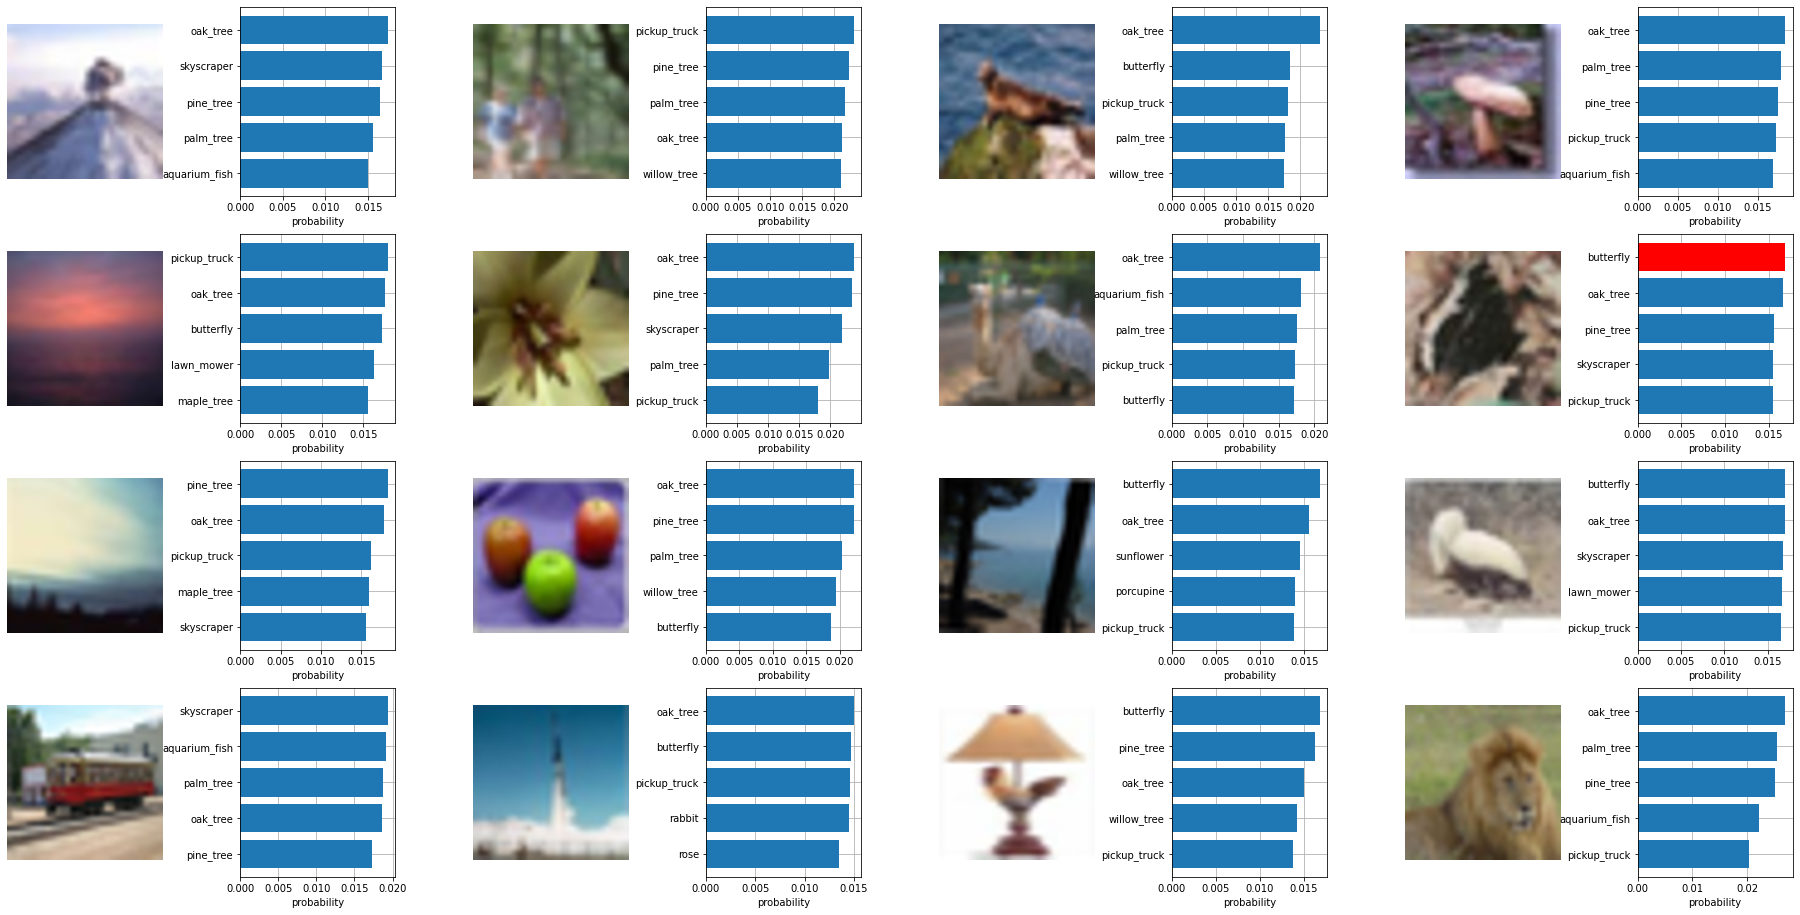

In [27]:
rows, cols = 4, 4
plt.figure(figsize=(cols*8, rows*4))

for i, image in enumerate(image_input[:rows*cols]):
    plt.subplot(rows, cols * 2, 2 * i + 1)
    plt.imshow(denormalize(image.cpu()).permute(1, 2, 0))
    plt.axis("off")

    plt.subplot(rows, cols * 2, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    if image_labels[i] in top_labels[i]:
      j = list(top_labels[i]).index(image_labels[i])
      plt.barh([j], [top_probs[i][j]], color='r')
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

### templates

In [28]:
templates80 = [
    'a bad photo of a {}.',
    'a photo of many {}.',
    'a sculpture of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.',
    'graffiti of a {}.',
    'a bad photo of the {}.',
    'a cropped photo of the {}.',
    'a tattoo of a {}.',
    'the embroidered {}.',
    'a photo of a hard to see {}.',
    'a bright photo of a {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a drawing of a {}.',
    'a photo of my {}.',
    'the plastic {}.',
    'a photo of the cool {}.',
    'a close-up photo of a {}.',
    'a black and white photo of the {}.',
    'a painting of the {}.',
    'a painting of a {}.',
    'a pixelated photo of the {}.',
    'a sculpture of the {}.',
    'a bright photo of the {}.',
    'a cropped photo of a {}.',
    'a plastic {}.',
    'a photo of the dirty {}.',
    'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.',
    'a photo of the {}.',
    'a good photo of the {}.',
    'a rendering of the {}.',
    'a {} in a video game.',
    'a photo of one {}.',
    'a doodle of a {}.',
    'a close-up photo of the {}.',
    'a photo of a {}.',
    'the origami {}.',
    'the {} in a video game.',
    'a sketch of a {}.',
    'a doodle of the {}.',
    'a origami {}.',
    'a low resolution photo of a {}.',
    'the toy {}.',
    'a rendition of the {}.',
    'a photo of the clean {}.',
    'a photo of a large {}.',
    'a rendition of a {}.',
    'a photo of a nice {}.',
    'a photo of a weird {}.',
    'a blurry photo of a {}.',
    'a cartoon {}.',
    'art of a {}.',
    'a sketch of the {}.',
    'a embroidered {}.',
    'a pixelated photo of a {}.',
    'itap of the {}.',
    'a jpeg corrupted photo of the {}.',
    'a good photo of a {}.',
    'a plushie {}.',
    'a photo of the nice {}.',
    'a photo of the small {}.',
    'a photo of the weird {}.',
    'the cartoon {}.',
    'art of the {}.',
    'a drawing of the {}.',
    'a photo of the large {}.',
    'a black and white photo of a {}.',
    'the plushie {}.',
    'a dark photo of a {}.',
    'itap of a {}.',
    'graffiti of the {}.',
    'a toy {}.',
    'itap of my {}.',
    'a photo of a cool {}.',
    'a photo of a small {}.',
    'a tattoo of the {}.',
]
templates7 = '''itap of a {}.
a bad photo of the {}.
a origami {}.
a photo of the large {}.
a {} in a video game.
art of the {}.
a photo of the small {}.'''.split('\n')

### zeroshot evaluation

In [29]:
import tqdm

def zeroshot_classifier(classnames, templates):
  with torch.no_grad():
    zeroshot_weights = []
    for classname in tqdm.tqdm(classnames):
      texts = [template.format(classname) for template in templates] #format with class
      texts = clip.tokenize(texts).cuda() #tokenize
      class_embeddings = encode_text(student_model_text, texts) #embed with text encoder
      class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
      class_embedding = class_embeddings.mean(dim=0)
      class_embedding /= class_embedding.norm()
      zeroshot_weights.append(class_embedding)
    zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
  return zeroshot_weights


zeroshot_weights = zeroshot_classifier(cifar100.classes, templates7)
zeroshot_weights_ = zeroshot_classifier(cifar100.classes, templates80)
zeroshot_weights.shape, zeroshot_weights_.shape

100%|██████████| 100/100 [00:04<00:00, 24.58it/s]


(torch.Size([512, 100]), torch.Size([512, 100]))

In [30]:
def accuracy(output, target, topk=(1,)):
  pred = output.topk(max(topk), 1, True, True)[1].t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]

with torch.no_grad():
  top1, top5, top1_, top5_, n = 0., 0., 0., 0., 0.
  for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
    images = images.cuda()
    target = target.cuda()

    # predict
    image_features = model.encode_image(images.half())
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # measure accuracy
    logits = 100. * image_features @ zeroshot_weights
    acc1, acc5 = accuracy(logits, target, topk=(1, 5))
    top1 += acc1
    top5 += acc5
    logits = 100. * image_features @ zeroshot_weights_
    acc1, acc5 = accuracy(logits, target, topk=(1, 5))
    top1_ += acc1
    top5_ += acc5

    n += images.size(0)

top1 = (top1 / n) * 100
top5 = (top5 / n) * 100 
top1_ = (top1_ / n) * 100
top5_ = (top5_ / n) * 100 

print()
print(f"Top-1 accuracy: {top1:.2f} {top1_:.2f}")
print(f"Top-5 accuracy: {top5:.2f} {top5_:.2f}")


# batch_size=128

# RN50
# Top-1 accuracy: 40.93 41.04 -- expected 41.6
# Top-5 accuracy: 73.14 72.37

# B/32
# Top-1 accuracy: 64.58 64.21 -- expected 65.1
# Top-5 accuracy: 88.61 88.08


# verified that batch_size=32 reproduce the same results:

# B/32
# Top-1 accuracy: 64.58 64.21 -- expected 65.1
# Top-5 accuracy: 88.61 88.08


# => missing ~0.5% with templates7 (~0.6% with templates80)
# CIFAR100
# STL10
# CIFAR100 - vision student model
CIFAR100 - text student model

100%|██████████| 79/79 [00:30<00:00,  2.63it/s]


Top-1 accuracy: 1.12 1.03
Top-5 accuracy: 6.00 6.07


Expected results from
https://arxiv.org/abs/2103.00020

![table 11](https://i.imgur.com/An5eEsm.png)